# Pre-test, OVB, Post-Double Selection e Double Debiased Machine Learning

Prof. Daniel de Abreu Pereira Uhr


### Conteúdo
* Introdução
* Pre-test
  * Quando o pre-test não é um problema?
  * Quando o pre-test é um problema?
* Viés de Variável Omitida (*Omitted Variable Bias - OVB*)
* Post-Double Selection (Seleção Pós-Dupla)
* Aprendizado de Máquina com Duplo Desviés (*Double Debiased Machine Learning*)
* Considerações Finais

### Referências

* A. Belloni, D. Chen, V. Chernozhukov, C. Hansen, Sparse Models and Methods for Optimal Instruments With an Application to Eminent Domain (2012), Econometrica.
* A. Belloni, V. Chernozhukov, C. Hansen, Inference on treatment effects after selection among high-dimensional controls (2014), The Review of Economic Studies.
* V. Chernozhukov, D. Chetverikov, M. Demirer, E. Duflo, C. Hansen, W. Newey, J. Robins, Double/debiased machine learning for treatment and structural parameters (2018), The Econometrics Journal.
* P. Hünermund, B. Louw, I. Caspi, Double Machine Learning and Automated Confounder Selection - A Cautionary Tale (2022), working paper.



***Disclaimer:*** *O material apresentado aqui é uma adaptação do material de aula do Prof. Daniel de Abreu Pereira Uhr, e não deve ser utilizado para fins comerciais. O material é disponibilizado para fins educacionais e de pesquisa, e não deve ser reproduzido sem a devida autorização do autor. Este material pode conter erros e imprecisões. O autor não se responsabiliza por quaisquer danos ou prejuízos decorrentes do uso deste material. O uso deste material é de responsabilidade exclusiva do usuário. Caso você encontre erros ou imprecisões neste material, por favor, entre em contato com o autor para que possam ser corrigidos. O autor agradece qualquer feedback ou sugestão de melhoria.*

Configuração do sistema


In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Introdução

Em um experimento controlado e aleatorizado (*Randomized Controlled Trial* - RCT), o tratamento ($D$) é aleatoriamente atribuído aos participantes, o que permite que os pesquisadores isolem o efeito do tratamento sobre o resultado. E o uso de variáveis de controle ($X$) é geralmente desnecessário, pois a aleatorização garante que os grupos de tratamento e controle sejam comparáveis em todas as características observadas e não observadas. Logo, a utilização das variáveis de controle teria um papel secundário, como o de aumentar o poder estatístico da análise, ao reduzir a variância do estimador.

Entretanto, em estudos observacionais, onde não há aleatorização do tratamento, o uso de variáveis de controle torna-se essencial para tentar recuperar os efeitos causais. Nesse contexto, as variáveis de controle são utilizadas para ajustar as diferenças pré-existentes entre os grupos de tratamento e controle, permitindo uma melhor aproximação do efeito causal.

Em muitos casos, principalmente nos últimos anos devido ao avanço computacional e de armazenagem de informação, o pesquisador dispõe de um grande número de variáveis de controle (*eventualmente, um numero de variáveis maior que o tamanho da amostra*), e surge a necessidade de selecionar aquelas mais relevantes, eventualmente capturando não linearidades e interações. Algoritmos de aprendizado de máquina são particularmente adequados para essa tarefa. No entanto, nesses casos, podemos introduzir um viés chamado de regularização ou pré-teste (Regularization - Pre-test), ou viés de seleção de características. 

Nesta aula, examinaremos a origem desse viés e apresentaremos uma das soluções mais influentes na última década na interseção entre aprendizado de máquina e inferência causal: o **Aprendizado de Máquina com Duplo Desviés** (*Double Debiased Machine Learning - DDML*).

Nosso roteiro, antes de chegar no DDML, será:
* Pré-teste (Pre-test)
* Viés de Variável Omitida (*Omitted Variable Bias - OVB*)
* Post-Double Selection (Seleção Pós-Dupla)

### Pre-test (Pré-teste)

Tenha em mente que estamos no contexto de estudos observacionais, com muitas possiveis variáveis de controle, e o pesquisador está interessado em selecionar as variáveis de controle mais relevantes para incluir no modelo de regressão.

O ***viés de pre-test*** (também chamado de viés de Regularização, ou de Seleção de Características) ocorre quando ***o pesquisador utiliza as variáveis de controle para decidir, COM BASE NOS DADOS, quais delas incluir no modelo final***. Essa seleção pode ser feita, por exemplo, com base em:
* testes estatísticos (por exemplo, se a variável é estatísticamente significativa), 
* algoritmos de seleção de variáveis ou, 
* por meio de algoritmos de aprendizado de máquina com regularização.

Embora essas abordagens possam melhorar a qualidade da previsão, elas podem comprometer a validade da inferência causal. O motivo é que a seleção baseada nos dados *introduz dependência entre os estimadores e o processo de seleção*, violando pressupostos fundamentais da teoria da inferência estatística clássica.

Na prática, isso significa que:

* O estimador do efeito do tratamento ($\hat{\alpha}$ associado à $D$) torna-se enviesado;
* A estimativa de seu erro padrão também se torna inválida, dificultando a construção de intervalos de confiança confiáveis;
* Mesmo modelos lineares, como o OLS, sofrem com esse problema se a inclusão ou exclusão de variáveis for condicionada aos próprios dados.

Do ponto de vista do *Machine Learning*, este fenômeno é um exemplo de *overfitting* inferencial: o modelo se adapta tão bem aos dados observados que perde a validade fora da amostra ou sob pequenas perturbações nos dados.

A solução para esse problema começa com a separação clara entre modelos de previsão (com alta capacidade de ajuste e regularização) e modelos de inferência causal, que precisam ser robustos a esse tipo de viés.


***Exemplo***

Suponha que fomos contratados por uma empresa para identificar ​o efeito dos gastos com publicidade na receita. O proprietário da empresa quer responder a seguinte pergunta:

* Vale a pena investir em publicidade? 

Como especialistas, sabemos que há muitos fatores que podem influenciar as vendas. Vamos supor que para esse caso a literatura sugere que uma medida de gestão (*Management* - índice/medida de capacidade de gestão) da loja pode controlar todos esses possíveis fatores. Mas temos dúvidas em utilizá-la ou não.

Vejamos no python. Vamos gerar os dados, e carregá-lo.

In [2]:
class dgp_pretest():
    """
    Data Generating Process: pre-test bias
    """
    
    def generate_data(self, a=1, b=.3, c=3, N=1000, seed=1):
        np.random.seed(seed)
        
        # Management
        Manag = np.random.normal(5, 1, N)
        
        # Advertisement 
        ads = c*Manag + np.random.normal(-3, 1, N)
        
        # Sales
        sales = a*ads + b*Manag + np.random.normal(0, 1, N)
                
        # Generate the dataframe
        df = pd.DataFrame({'ads': ads, 'sales': sales, 'Manag': Manag})

        return df

In [3]:
dgp = dgp_pretest()
df = dgp.generate_data()
df

,ads,sales,Manag
0,16.719800,19.196620,6.624345
1,7.732222,9.287491,4.388244
2,10.923469,11.816906,4.471828
3,8.457062,9.024376,3.927031
4,13.085146,12.814823,5.865408
...,...,...,...
995,11.839250,12.532427,4.883556
996,5.729024,5.923178,2.722702
997,10.869467,12.197920,4.930375
998,13.708986,13.915125,5.353870


Temos um dataframe com 1000 observações (empresas diferentes) e 3 variáveis: vendas ($Sales$), gastos com publicidade ($ads$) e gestão ($Manag$).

***A pergunta que queremos responder é: qual é o efeito dos gastos com publicidade nas vendas?***

Basicamente, podemos modelar de 2 formas diferentes:

* **Modelo Curto**

$$ Sales_{i} = \theta + \alpha ads_{i} + \epsilon_{i} $$

* **Modelo Longo**

$$ Sales_{i} = \theta + \alpha ads_{i} + \beta Manag_{i} + \epsilon $$


Surge a dúvida, deveríamos controlar a gestão da firma? Ou seja, devemos incluir a variável $Manag$ no modelo? 

Como não temos certeza. Poderíamos deixar os ***dados decidirem***. Isto é, caso o coeficiente de $Manag$ seja estatisticamente significativo, incluímos a variável, e utilizamos o modelo longo. Caso contrário, utilizamos o modelo curto.

In [4]:
smf.ols('sales ~ ads + Manag', df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.1405,0.185,0.758,0.448,-0.223,0.504
ads,0.9708,0.030,32.545,0.000,0.912,1.029
Manag,0.3381,0.095,3.543,0.000,0.151,0.525


Segundo a regressão, o coeficiente de $Manag$ é positivo e estatisticamente significativo, então, seguindo o critério de significância estatística na regressão (Pre-Test), utilizamos o modelo longo.

### Viés de Variável Omitida (*Omitted Variable Bias - OVB*)

O procedimento anterior de Pre-test (Regularização, ou Seleção de Características) pode estar introduzindo um viés no estimador do efeito do tratamento ($\hat{\alpha}D$). Isso ocorre porque ***a decisão de incluir ou não a variável de controle foi tomada com base nos dados***, o que cria uma ***dependência entre o processo de seleção e o estimador***.


***Quando o pre-test não é um problema?***

Vamos realizar simulações para entender melhor a questão. No nosso caso, temos acesso ao processo gerador de dados (contrário do que ocorre na vida real). Então, vamos testar o que aconteceria se repetíssemos o procedimento várias vezes:

1. Extraimos uma nova amostra do processo de geração de dados;
2. Regredimos $Sales$ em $ads$ e $Manag$;
3. Se o coeficiente de $Manag$ for significativo no nível de 95%, mantemos o modelo longo.
4.  Caso contrário, regredimos $sales$ em $ads$ apenas (modelo curto), e mantemos esse coeficiente.

Ou seja, estamos testando o efeito de $Manag$ em $Sales$, mas o coeficiente de interesse é o de $ads$ ($\alpha$).

Mantenha em mente que a estimação correta dos coeficientes depende da especificação correta do modelo. E o modelo completo (modelo longo) é o correto, pois inclui todas as variáveis relevantes. Logo, o modelo curto seria uma especificação incorreta.

In [5]:
def pre_testing(d='ads', y='sales', x='Manag', K=1000, **kwargs):
    
    # Init
    alpha = {'Long': np.zeros(K), 'Short': np.zeros(K), 'Pre-test': np.zeros(K)}

    # Loop over simulations
    for k in range(K):
        
        # Generate data
        df = dgp_pretest().generate_data(seed=k, **kwargs)
        
        # Compute coefficients
        alpha['Long'][k] = smf.ols(f'{y} ~ {d} + {x}', df).fit().params[1]
        alpha['Short'][k] = smf.ols(f'{y} ~ {d}', df).fit().params[1]
    
        # Compute significance of beta
        p_value = smf.ols(f'{y} ~ {d} + {x}', df).fit().pvalues[2]
        
        # Select specification based on p-value
        if p_value<0.05:
            alpha['Pre-test'][k] = alpha['Long'][k]
        else:
            alpha['Pre-test'][k] = alpha['Short'][k]
    
    return alpha

alphas = pre_testing()

Agora podemos traçar as distribuições (por meio de simulações) dos coeficientes estimados.

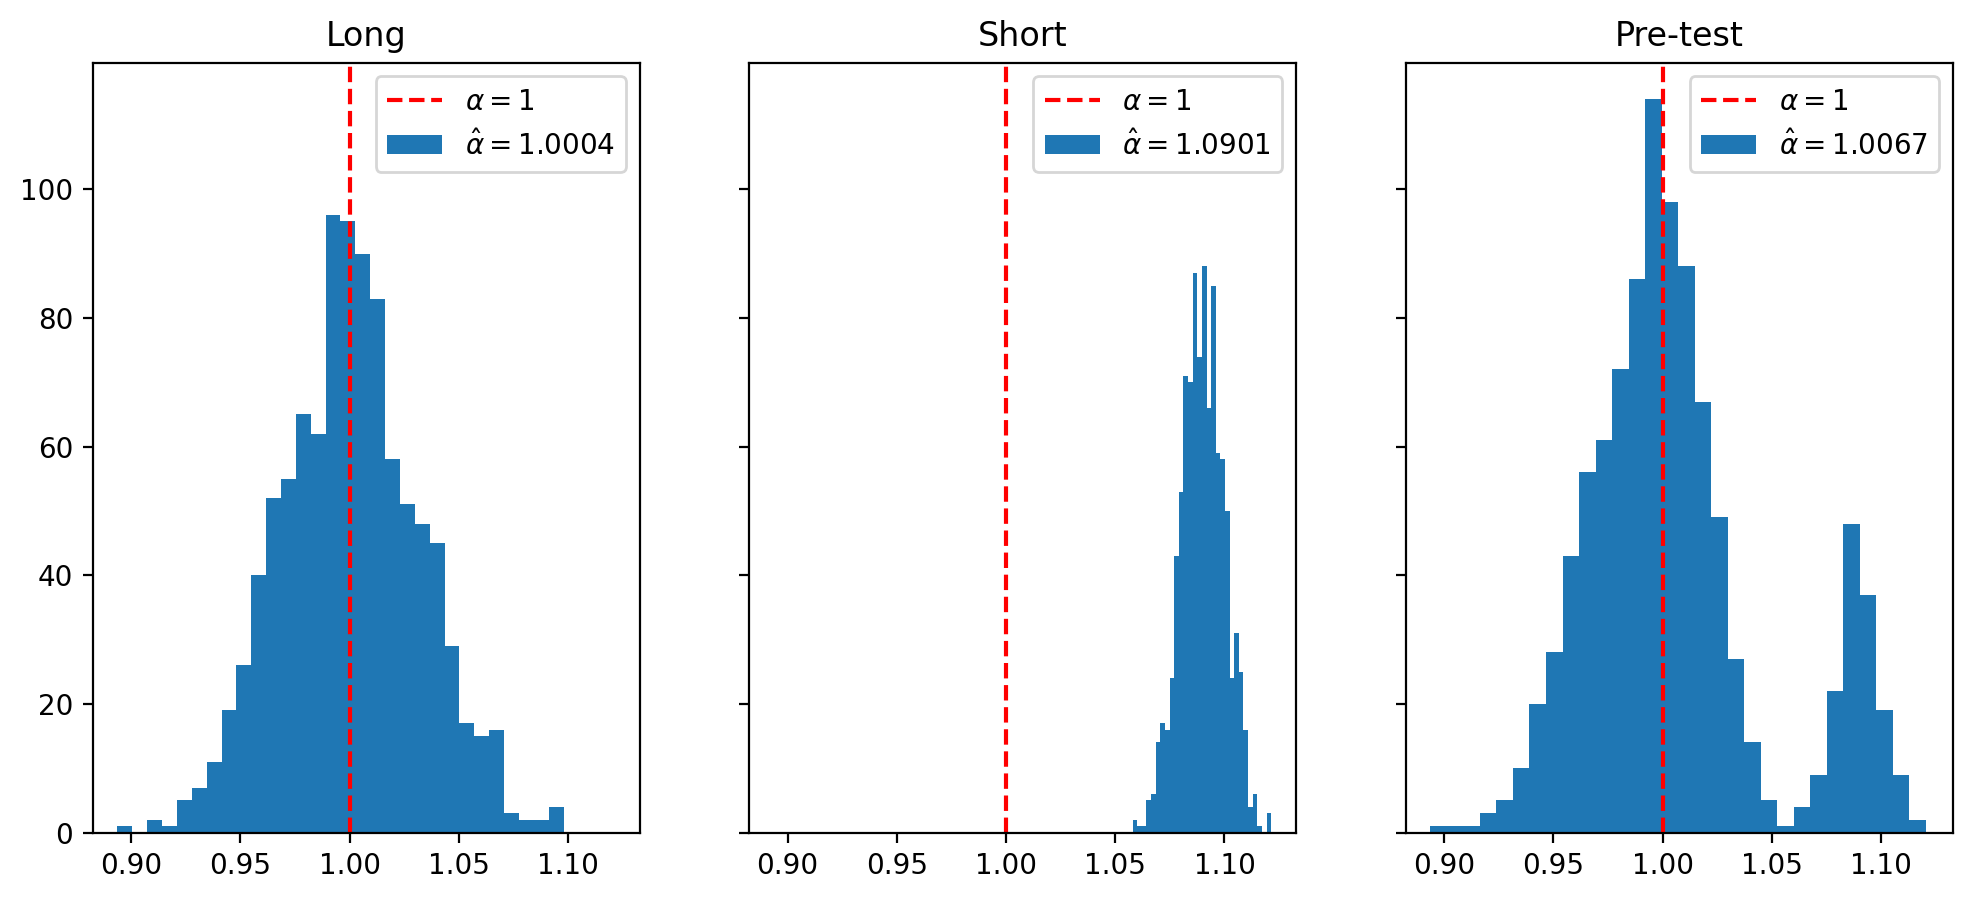

In [6]:
def plot_alphas(alphas, true_alpha):
    
    # Init plot
    fig, axes = plt.subplots(1, len(alphas), figsize=(4*len(alphas), 5), sharey=True, sharex=True)

    # Make one plot for each set of coefficients
    for i, key in enumerate(alphas.keys()):
        axes[i].hist(alphas[key], bins=30, lw=.1)
        axes[i].set_title(key)
        axes[i].axvline(true_alpha, c='r', ls='--')
        legend_text = [r'$\alpha=%.0f$' % true_alpha, r'$\hat \alpha=%.4f$' % np.mean(alphas[key])]
        axes[i].legend(legend_text, prop={'size': 10}, loc='upper right')

plot_alphas(alphas, true_alpha=1)

Podemos ver que no primeiro gráfico, se estivéssemos sempre executando a regressão longa, o coeficiente $\alpha_{long}$ seria não viesada e normalmente distribuída, enquanto o coeficiente $\alpha_{\text{short}}$ seria enviesado (tendencioso).

O procedimento de pre-test gera o estimador $\hat{\alpha}_{pre-test}$ que mistura os dois casos porque em algumas simulações o procedimento de pre-test seleciona o modelo curto, que é enviesado, e na maioria das vezes o modelo longo, que não é enviesado (como podemos ver no gráfico da direita). 

Então, o procedimento de pre-test ***distorce a inferência***, no caso, a distribuição do estimador $\hat{\alpha}_{pre-test}$ não é mais normal, mas bimodal. A consequencia disso é que os ***intervalos de confiança para o coeficiente terão intervalos errados*** (os intervalos conterão o efeito verdadeiro com uma probabilidade diferente da alegada).

***Quando o pre-test é um problema?***

O Pre-test é um problema quando executamos a regressão curta, e a variável de Gestão da Empresa (*Management*), que era relevante para o modelo, é omitida da estimação. Entramos no chamado ***Viés de Variável Omitida (*Omitted Variable Bias - OVB*)***.

Em geral, o OVB surge quando uma variável relevante (*Manag* ou $X$) para o modelo é omitida, e essa variável está correlacionada com a variável de interesse (no nosso caso, $ads$ ou $D$). Isso leva a uma estimativa enviesada do coeficiente da variável de interesse ($D$) sobre o resultado ($Y$).

Em termos de magnitude, o OVB pode ser expresso como:

$$ \text{OVB} = \beta \delta $$

onde

$$ \beta = \frac{\text{Cov}(X, Y)}{\text{Var}(X)} $$ 

e

$$ \delta = \frac{\text{Cov}(X, D)}{\text{Var}(X)} $$



onde $\beta$ é o efeito da variável omitida ($X$) no resultado ($Y$), e $\delta$ é o efeito da variável omitida ($X$) na variável de interesse ($D$).

O ***pre-test é um problema*** se:
* (i) rodamos uma regressão curta em vez da longa, e 
* (ii) o efeito do viés é sensível (tamanho da amostra? à magnitude do coeficiente?).

***O tamanho da amostra importa***

Como em algumas amostras o coeficiente de $Manag$ é não significativo, acabamos rodando a regressão curta, e o coeficiente $\hat{\alpha}_{short}$ é enviesado.

Uma forma de rejeitar corretamente a hipótese de que $H_{0}: \beta  = 0$ é que o tamanho da amostra seja maior. 

Com mais observações podemos estimar com mais precisão e será menos provavel cometer um erro tipo II (não rejeitar a hipótese nula quando ela é falsa), ou seja, executar a regressão curta quando deveríamos ter executado a longa.

Vamos simular o coeficiente estimado sob diferentes tamanhos de amostra.

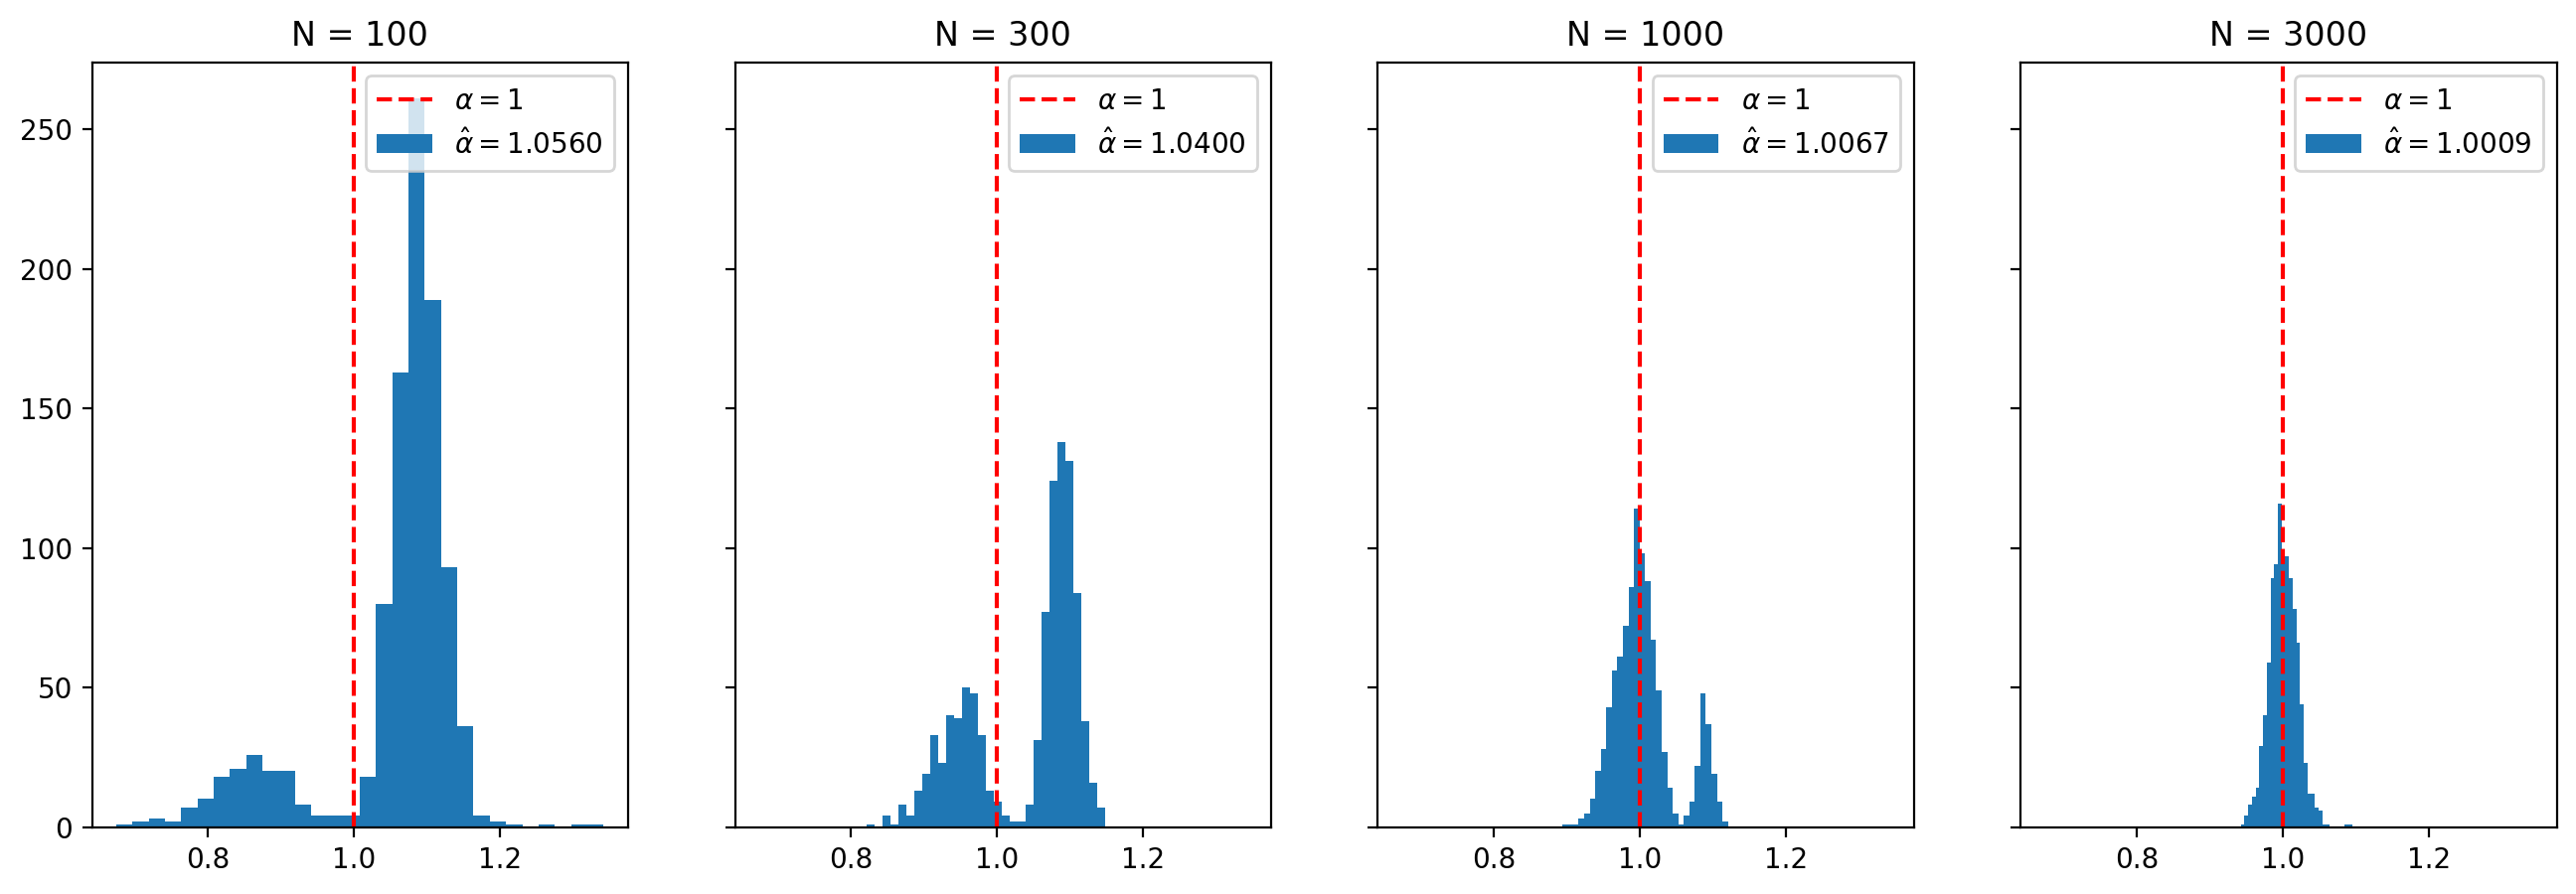

In [10]:
Ns = [100,300,1000,3000]
alphas = {f'N = {n:.0f}':  pre_testing(N=n)['Pre-test'] for n in Ns}
plot_alphas(alphas, true_alpha=1)

Repare que à medida que o tamanho da amostra aumenta (da esquerda para a direita), o viés diminui e a distribuição do estimador
converge para uma distribuição normal.

***A magnitude do beta***

O que aconteceria se o valor de $\beta$ fosse diferente?

* Se $\beta$ é ***muito pequeno***, será difícil detectá-lo e, muitas vezes, acabaremos executando a regressão curta, introduzindo um viés. No entanto, se
é muito pequeno, isso também implica que ***a magnitude do viés*** é pequena e, portanto, não afetará muito nossa estimativa de $\alpha$.
* Se $\beta$ é ***muito grande***, será fácil de detectar e muitas vezes acabaremos executando a regressão longa, evitando o viés (que seria muito grande).

*Simulando sob diferentes valores de $\beta$*

O verdadeiro valor de $\beta$ é 0.3. Vamos simular para 0.03, 0.09, 0.3, e 0.9.

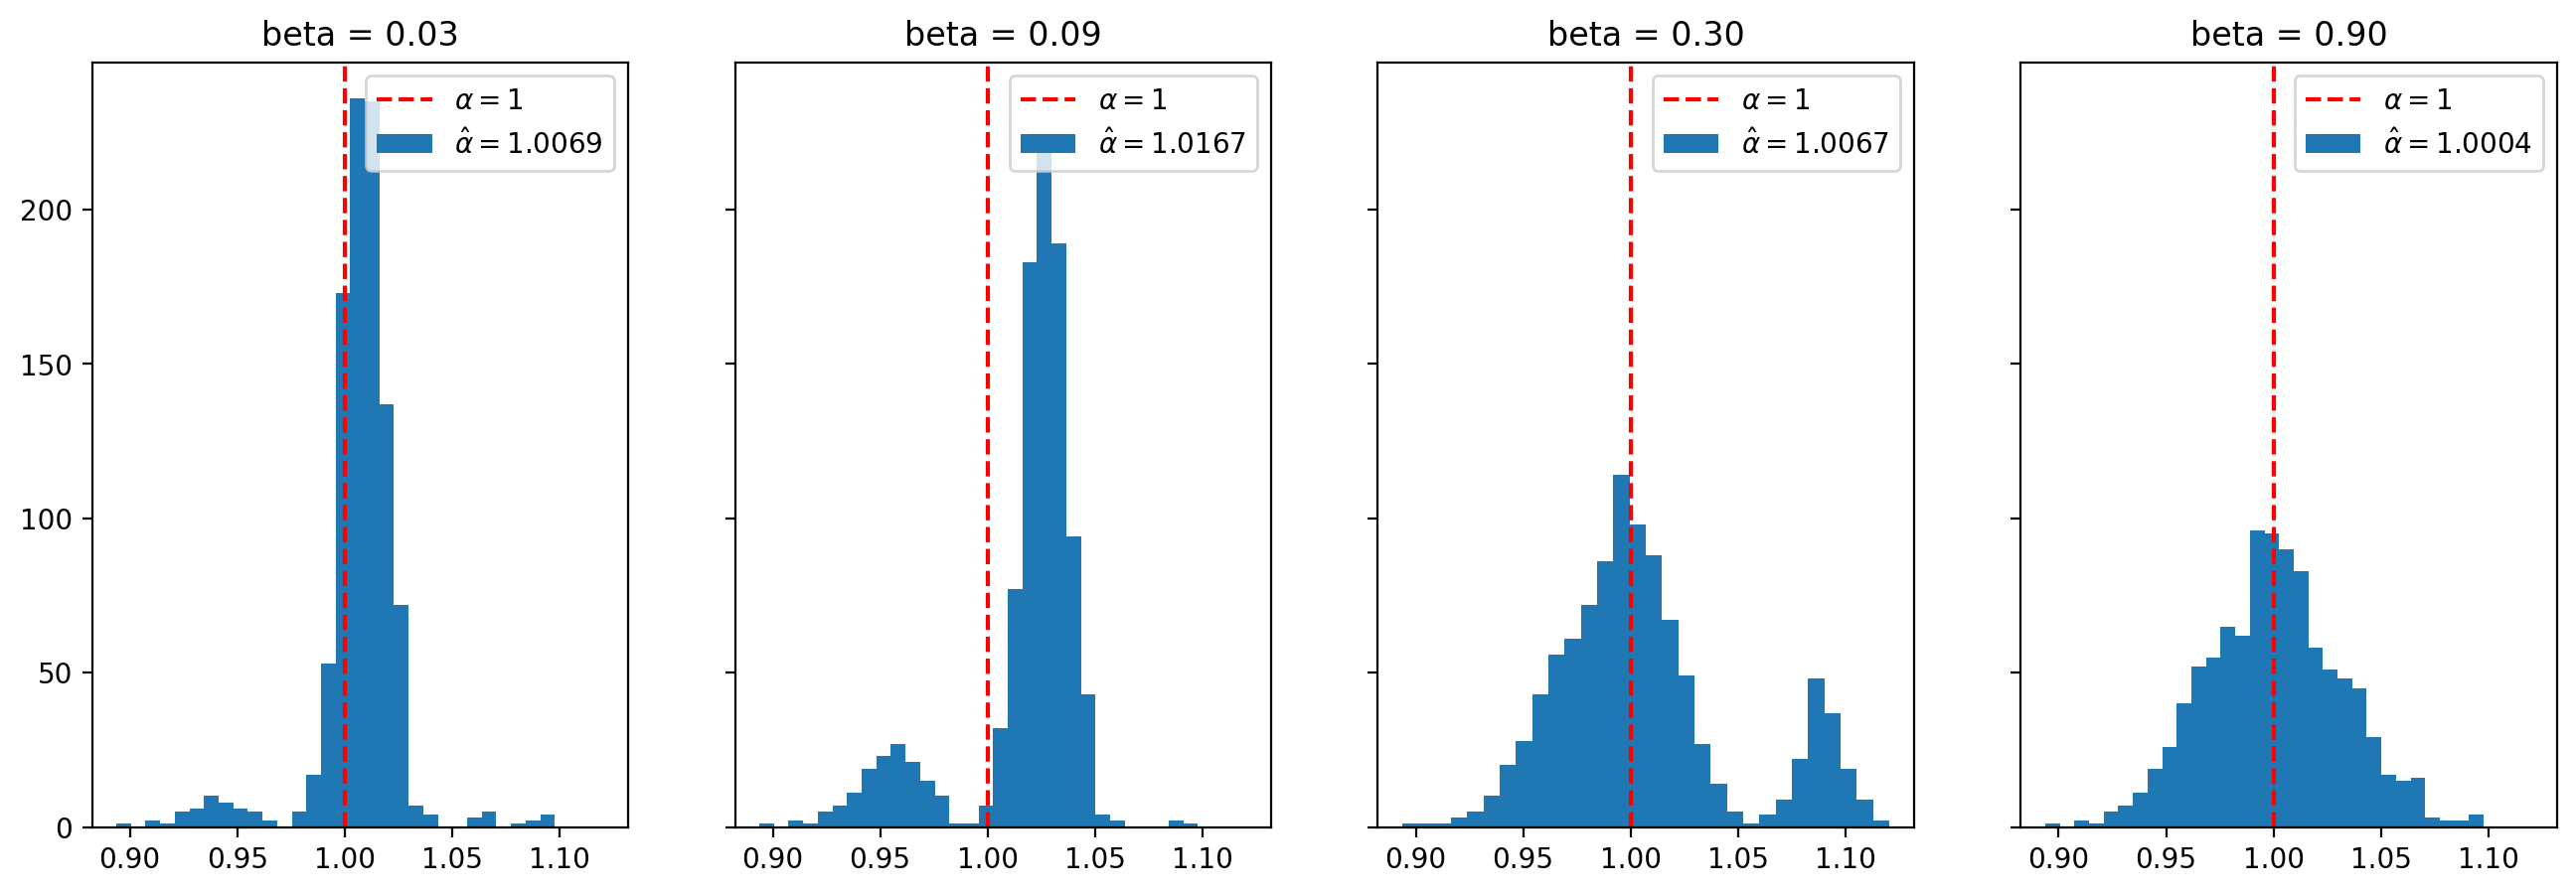

In [11]:
betas = 0.3 * np.array([0.1,0.3,1,3])
alphas = {f'beta = {b:.2f}':  pre_testing(b=b)['Pre-test'] for b in betas}
plot_alphas(alphas, true_alpha=1)

Como podemos ver nos gráficos, à medida que o valor de $\beta$ aumenta, o viés primeiro aparece e depois desaparece. Quando $\beta$ é pequeno (gráfico à esquerda), frequentemente escolhemos a regressão curta, mas o viés é pequeno e a estimativa média é muito próxima do valor real. Para valores intermediários de $\beta$, o viés é sensível e tem um efeito claro na inferência. Por último, em vez disso para grandes valores de $\beta$ (gráfico à direita), sempre executamos a regressão longa e o viés desaparece.

Mas ***quando um coeficiente é grande ou pequeno?***. Ou melhor, é ***grande ou pequeno em relação ao quê?*** 

Em estatística, ***um coeficiente não é avaliado apenas pelo seu valor numérico absoluto, mas sim em relação ao seu erro padrão*** (*Standard Error* - SE). Em outras palavras, ***o que importa é o tamanho do coeficiente comparado à incerteza na sua estimativa***.

Nós costumamos avaliar: 

* $H_{0}:\beta_k = 0$ contra $H_{1}:\beta_k \neq 0$.

​
Utilizamos o teste t de Student para avaliar a significância estatística do coeficiente $\hat{\beta}_k$:

$$ t = \frac{\hat{\beta}_k - \bar{\beta}_k}{\text{SE}(\hat{\beta}_k)} = \frac{\hat{\beta}_k - (0)}{\sqrt{\hat{\sigma}^2 (X'X)^{-1}_{kk}}} $$

ou seja, em termos de estimativa amostral:

$$ t = \frac{\hat{\beta}_k}{\sqrt{\frac{\frac{\sum_{i=1}^{n} \hat{u}_i^2}{n-K}}{\sum_{i=1}^{n}(x_{i}-\bar{x})^{2}}}} $$

Note que o erro padrão da estimativa, $\text{SE}(\hat{\beta}_k)$, depende:

* diretamente da variância residual estimada ($\sum \hat{u}_i^2$), e
* inversamente da variabilidade do regressor $x_k$ (capturada pela soma dos quadrados centrados).

À medida que o tamanho da amostra $n$ aumenta, o erro padrão tende a diminuir. Isso ocorre porque a variância dos estimadores amostrais tende a cair com o aumento da amostra — uma consequência direta do Teorema do Limite Central (TLC).

Formalmente, o TLC afirma que:

$$ \sqrt{n}(\bar{X} - \mu) \xrightarrow{d} N(0, \sigma^2) $$

* Lembre-se: o fator $\sqrt{n}$ é necessário para escalar a média amostral e obter uma distribuição limite não degenerada (normal com variância $\sigma^2$). $Var(\sqrt{n}(\bar{X} - \mu)) = n \cdot Var(\bar{X}) = n \cdot \frac{\sigma^2}{n} = \sigma^2$.

Embora essa fórmula envolva a média amostral $\bar{X}$, o mesmo princípio se aplica a estimadores como $\hat{\beta}_k$, que são combinações lineares de variáveis aleatórias. Assim, temos que:

$$\sqrt{n}(\hat{\beta}_k - \beta_k) \xrightarrow{d} N(0, \Omega) $$

* $\Omega$ é a matriz de variância-covariância assintótica do vetor de estimadores $\hat{\beta}$.
* $\text{Var}(\hat{\beta}_k) = \mathcal{O}\left(\frac{1}{n}\right)$. Ou seja, a variância da estimativa diminui à medida que a amostra cresce, refletindo menor incerteza nas inferências feitas com $\hat{\beta}_k$.

Conclusão: o tamanho de um coeficiente deve ser interpretado relativamente ao seu erro padrão, que por sua vez depende:
* do tamanho da amostra ($n$),
* da variância dos resíduos ($\hat{\sigma}^2$), e
* da variabilidade dos regressores ($x_k$).

Então, estimadores de $\hat{\beta}$ têm distribuição assintoticamente normal, com ***variância decrescendo*** na ordem de $\frac{1}{n}$ e, respectivamente, ***erro padrão decrescendo*** com $\frac{1}{\sqrt{n}}$. Portanto, a interpretação do tamanho de um coeficiente deve sempre levar em conta esse escalonamento: à medida que a amostra cresce, mesmo coeficientes menores podem se tornar estatisticamente significantes, pois a incerteza diminui.

A ideia é mais fácil de mostrar do que de explicar. Por isso, vamos repetir a simulação anterior, mas agora aumentando o coeficiente $\beta$ proporcionalmente ao inverso da raiz do tamanho da amostra:

$$ \beta = \frac{(0.3).30}{\sqrt{n}} $$

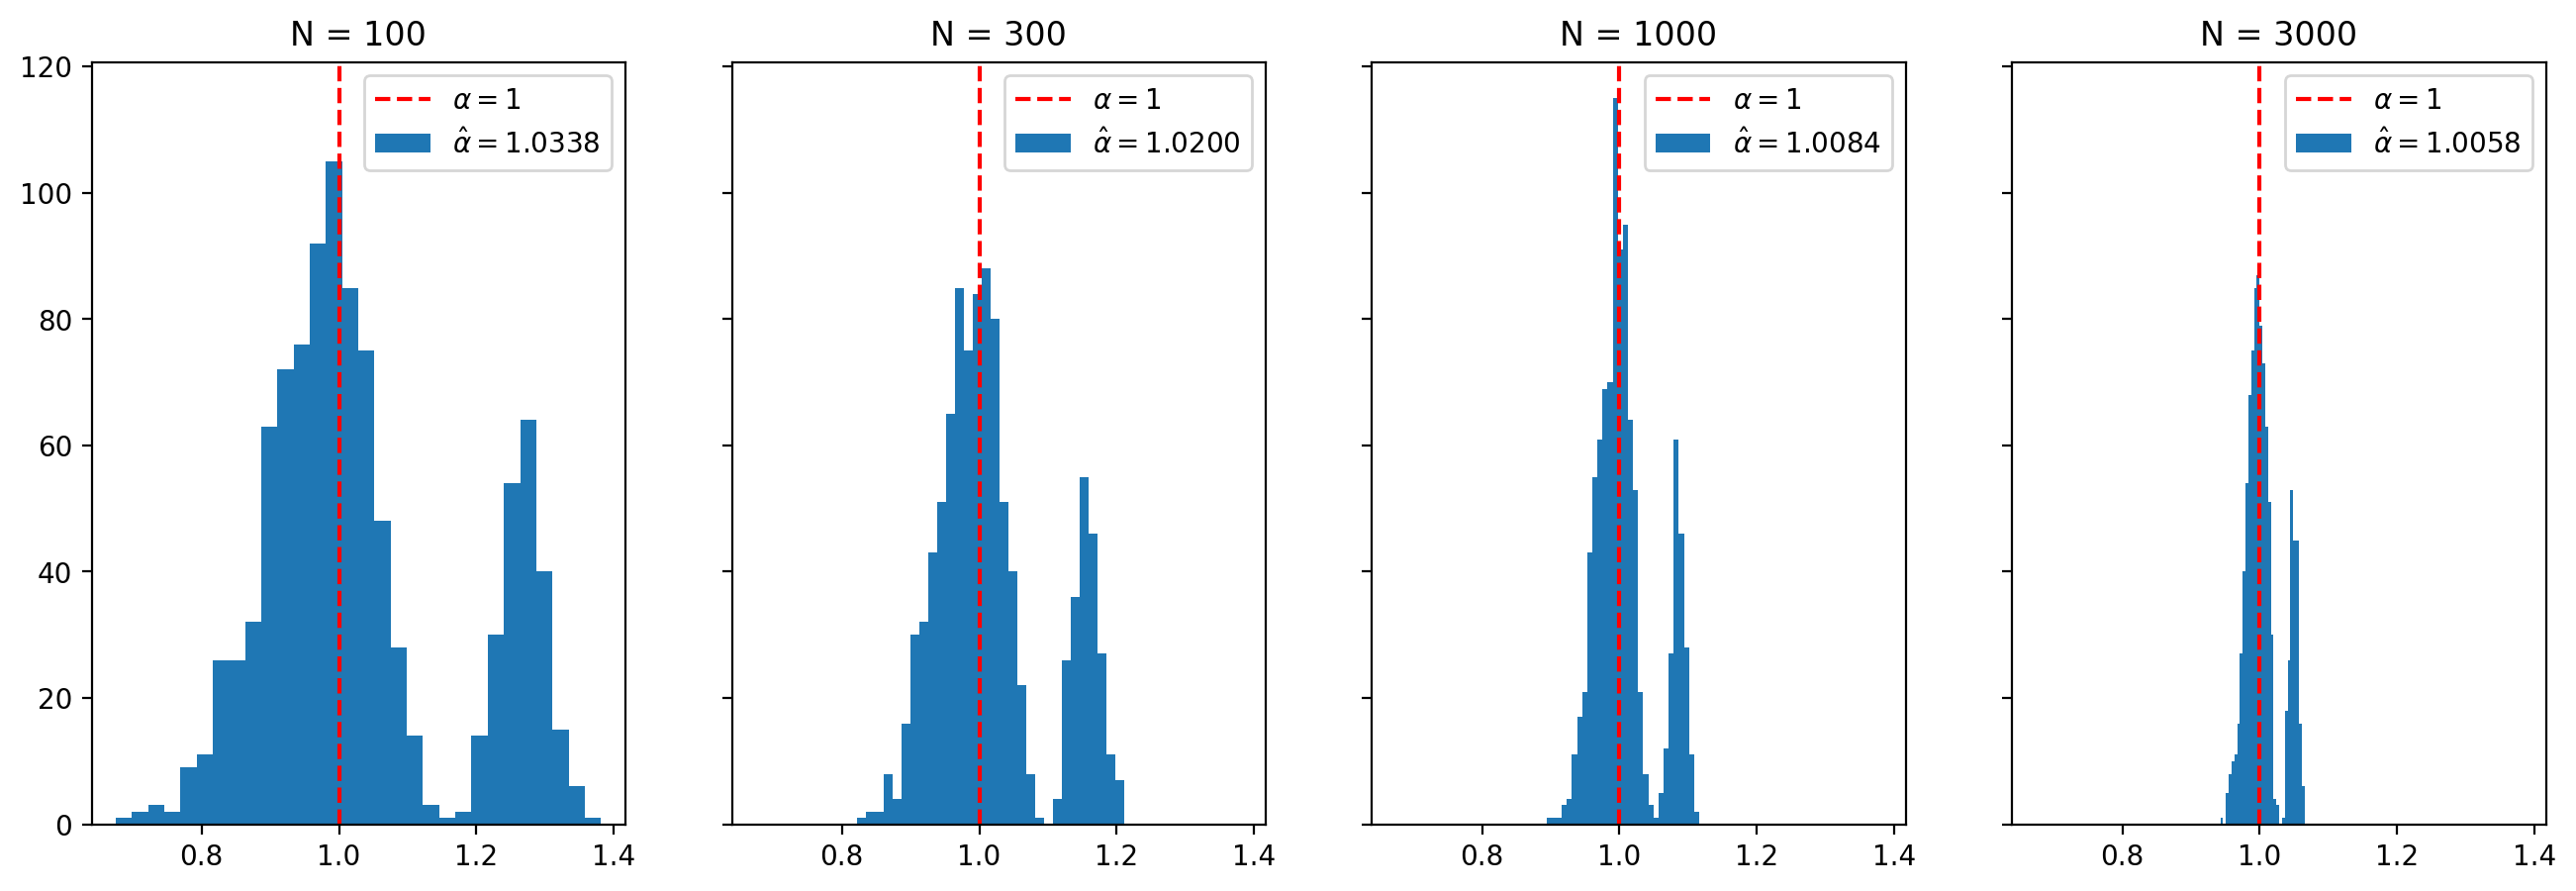

In [12]:
betas = 0.3 * 30 / np.sqrt(Ns)
alphas = {f'N = {n:.0f}':  pre_testing(b=b, N=n)['Pre-test'] for n,b in zip(Ns,betas)}
plot_alphas(alphas, true_alpha=1)

Como podemos ver, agora que $\beta$ é proporcional a  $\frac{1}{\sqrt{n}}$, a distorção não desaparece, independentemente do tamanho da amostra. Portanto, a inferência sempre estará errada.

Embora um coeficiente que depende do tamanho da amostra possa ***não parecer intuitivo***, ele captura bem a ideia de ***sensibilidade*** em um contexto onde fazemos inferências com base em resultados assintóticos, principalmente o Teorema do Limite Central. De fato, o Teorema do Limite Central se baseia em um tamanho de amostra infinitamente grande. *No entanto, com uma quantidade infinita de dados, nenhum coeficiente é pequeno e qualquer efeito diferente de zero é detectado com certeza*.

### Post-Double Selection

A solução para o problema do pre-test é conhecida como ***Post-Double Selection***, ou ***Seleção Pós-Dupla***. O método foi introduzido pela primeira vez em ***Belloni, Chernozhukov, Hansen (2014)*** e posteriormente expandido em outros artigos. O nome *Seleção pós-dupla* vem do fato de que agora não estamos realizando a seleção de variáveis ​​uma, mas duas vezes.

Os autores assumem o seguinte processo gerador dose dados:

$$ Y = \alpha D + \beta X + \epsilon $$

$$ D = \delta X + \eta $$

Seguindo nosso exemplo, $Y$ é o resultado (vendas), $D$ é a variável de tratamento (gastos com publicidade), $X$ são as variáveis de controle (Gestão da empresa), geralmente estamos interessados em casos onde $X$ é de alta dimensão, ou seja, com mais variáveis do que observações. Logo, a seleção de variáveis é essencial para a análise.

O procedimento de *Post-Double Selection* é o seguinte:
1. **Reduced Form Selection** (Seleção da forma reduzida): Lasso de $Y$ sobre $X$, e seleciona as  variáveis de controle estatísticamente significativas em um conjunto $S_{RF}$.
2. **First Stage Selection** (Seleção da primeira etapa): Lasso de $D$ sobre $X$. Seleciona as variáveis significativas em um conjunto $S_{FS}$.
3. Regressão de $Y$ sobre $D$ e a união das variáveis selecionadas nos dois primeiros passos: $S = S_{RF} \cup S_{FS}$.


Os autores mostram que este procedimento produz intervalos de confiança para o coeficiente de interesse $\alpha$ que tenham a cobertura correta, ou seja, a probabilidade correta de erro tipo 1.

Este procedimento é sempre menos parcimonioso, em termos de seleção de variáveis, do que o pré-teste. De fato, ainda selecionamos todas as variáveis ​​que teríamos selecionado no pré-teste, mas, na primeira etapa, podemos selecionar variáveis ​​adicionais


***Intuição***

A ideia por trás da pós-seleção dupla é: limitar o viés das variáveis ​​omitidas. Como vimos anteriormente:

$$ OVB = \beta \delta $$

onde 

$$ \beta = \frac{\text{Cov}(X, Y)}{\text{Var}(X)} $$

e

$$ \delta = \frac{\text{Cov}(X, D)}{\text{Var}(X)} $$


No nosso contexto, o viés da variável omitida é $\beta \delta $ queremos que ele convirja para zero mais rápido do que $\frac{1}{\sqrt{n}}$. 
 
* Seleção de forma reduzida (pré-teste): qualquer variável “ausente” $j$ tem $| \beta_{j}| \leq \frac{c}{\sqrt{n}} $
* Seleção do primeiro estágio (adicional): qualquer variável “ausente” $j$ e tem $|\delta_{i} | \leq \frac{c}{\sqrt{n}}$


$$|\text{OVB}_j| = |\beta_j \delta_j| \leq \frac{c^2}{n}$$

Como consequência, enquanto o número de variáveis omitidas for finito, o viés da variável omitida irá convergir para zero a uma taxa $\frac{1}{n}$, que é mais rápido que $\frac{1}{\sqrt{n}}$. 

***Aplicação***

Vamos agora voltar ao nosso exemplo e testar o procedimento de seleção pós-dupla. Na prática, queremos fazer o seguinte:

* Seleção do primeiro estágio $ads$ : regredir em *Manag*. Verifique se *Manag* é estatisticamente significativo
* Seleção de forma reduzida *sales* : regredir em *Manag*. Verifique se *Manag* é estatisticamente significativo
* Regredir *sales* e *ads* incluir *Manag* somente se foi significativo em qualquer uma das duas regressões anteriores
* Atualizo a função *pre_test* da primeira parte do post para calcular também o estimador de pós-seleção dupla.



In [13]:
def pre_test(d='ads', y='sales', x='Manag', K=1000, **kwargs):
    
    # Init
    alphas = pd.DataFrame({'Long': np.zeros(K), 
             'Short': np.zeros(K), 
             'Pre-test': np.zeros(K),
             'Post-double': np.zeros(K)})

    # Loop over simulations
    for k in range(K):
        
        # Generate data
        df = dgp_pretest().generate_data(seed=k, **kwargs)
        
        # Compute coefficients
        alphas['Long'][k] = smf.ols(f'{y} ~ {d} + {x}', df).fit().params[1]
        alphas['Short'][k] = smf.ols(f'{y} ~ {d}', df).fit().params[1]
    
        # Compute significance of beta and gamma
        p_value_ydx = smf.ols(f'{y} ~ {d} + {x}', df).fit().pvalues[2]
        p_value_yx = smf.ols(f'{y} ~ {x}', df).fit().pvalues[1]
        p_value_dx = smf.ols(f'{d} ~ {x}', df).fit().pvalues[1]
        
        # Select pre-test specification based on regression of y on d and x
        if p_value_ydx<0.05:
            alphas['Pre-test'][k] = alphas['Long'][k]
        else:
            alphas['Pre-test'][k] = alphas['Short'][k]
            
        # Select post-double specification based on regression of y on d and x
        if p_value_yx<0.05 or p_value_dx<0.05:
            alphas['Post-double'][k] = alphas['Long'][k]
        else:
            alphas['Post-double'][k] = alphas['Short'][k]
    
    return alphas

alphas = pre_test()

Agora podemos traçar as distribuições (por meio de simulações) dos coeficientes estimados.

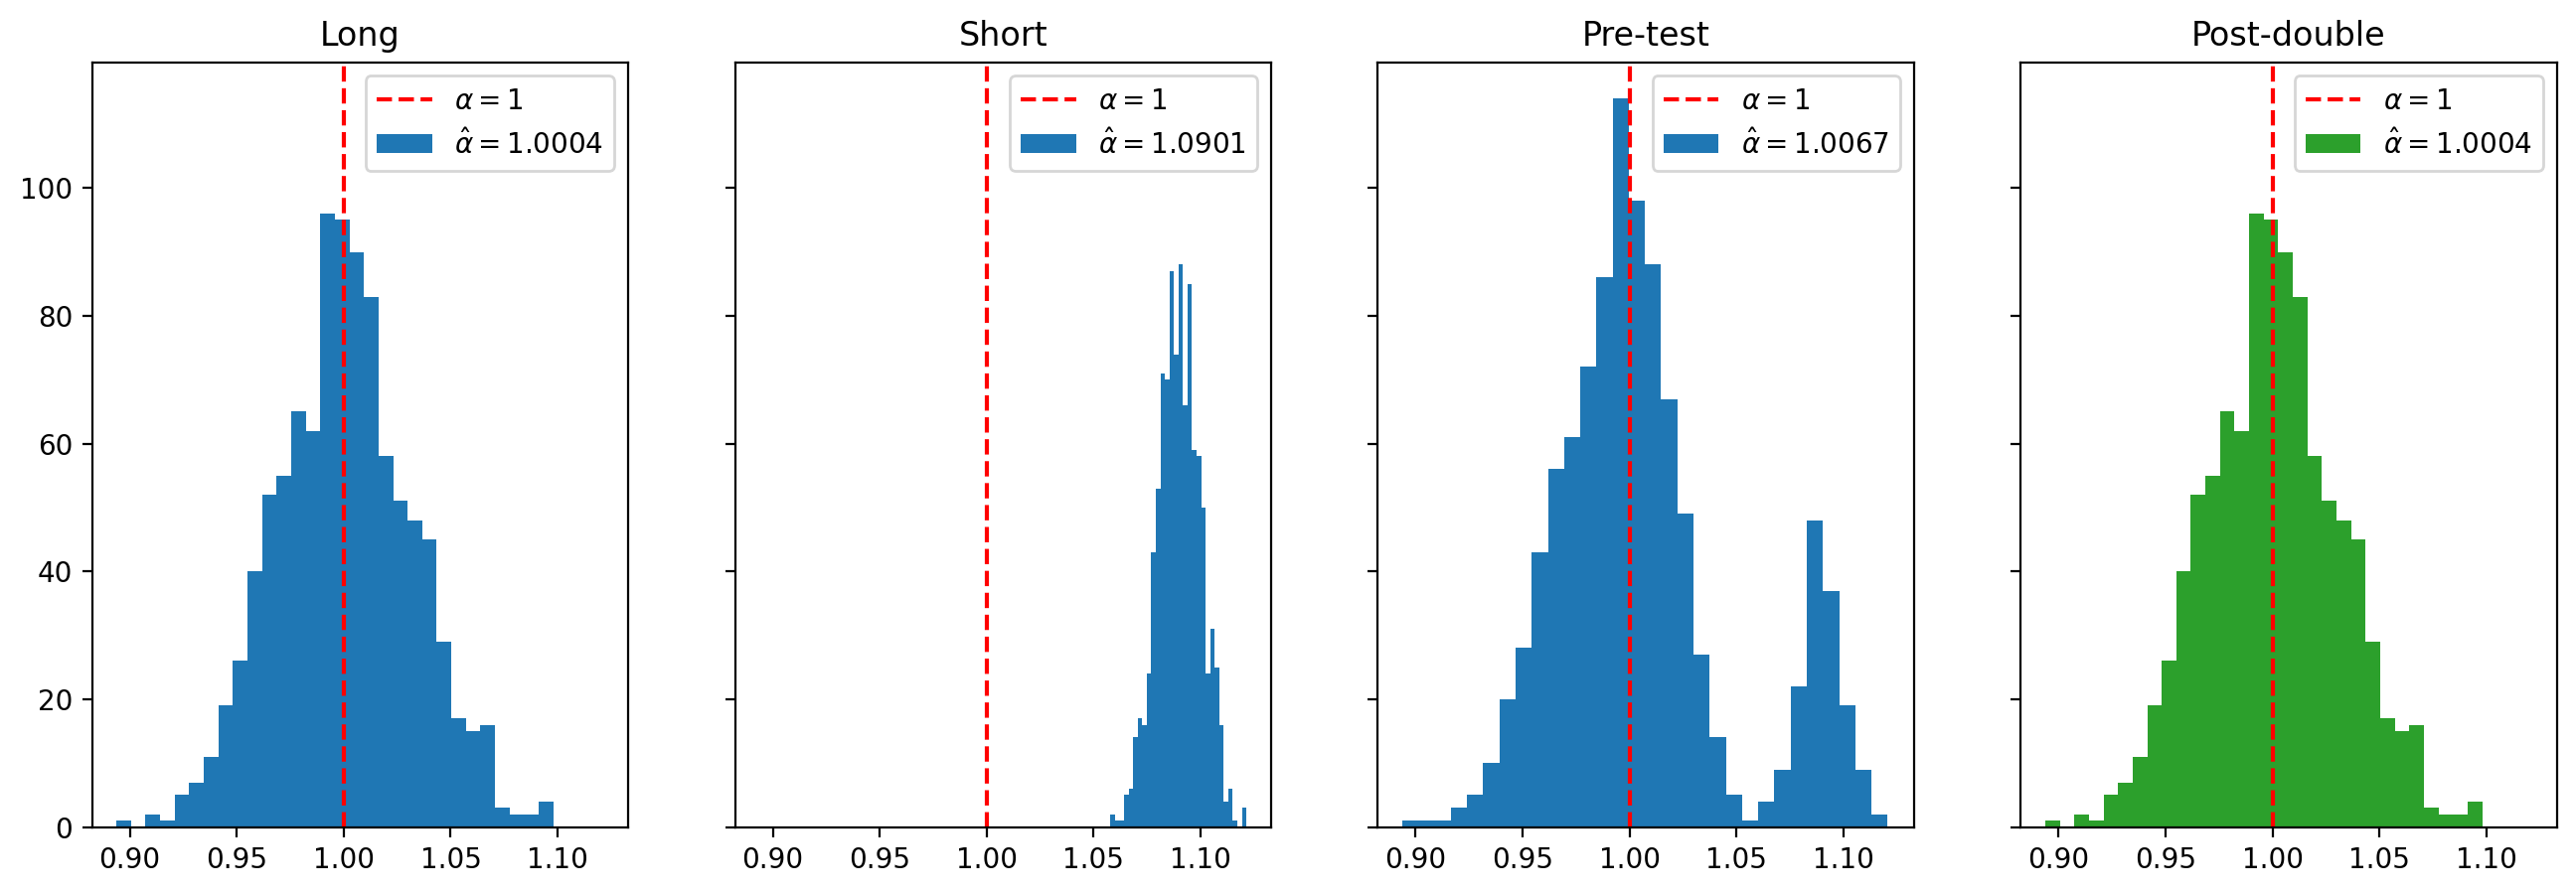

In [14]:
def plot_alphas(alphas, true_alpha):
    
    # Init plot
    K = len(alphas.columns)
    fig, axes = plt.subplots(1, K, figsize=(4*K, 5), sharey=True, sharex=True)

    # Make one plot for each set of coefficients
    for i, key in enumerate(alphas.columns):
        axes[i].hist(alphas[key].values, bins=30, lw=.1, color=f'C{int(i==3)*2}')
        axes[i].set_title(key)
        axes[i].axvline(true_alpha, c='r', ls='--')
        legend_text = [rf'$\alpha=${true_alpha}', rf'$\hat \alpha=${np.mean(alphas[key]):.4f}']
        axes[i].legend(legend_text, prop={'size': 10}, loc='upper right')

plot_alphas(alphas, true_alpha=1)

Como podemos ver, o estimador de seleção pós-dupla sempre seleciona corretamente a regressão longa e, portanto, tem a distribuição correta.

***Robustez do procedimento da seleção pós-dupla***

Anteriormente, realizamos algumas simulações para investigar quando surge o viés do pré-teste. Vimos que o pré-teste é um problema para

* Diferentes tamanhos de amostra (Tamanhos de amostra pequenos $n$).
* Diferentes valores de $\beta$.
* Valor de $\beta$ varia conforme o tamanho da amostra.

Vamos verificar se a seleção pós-dupla remove o viés de regularização em ***todos*** os casos anteriores.


***Diferentes tamanhos de amostra***

Primeiro, vamos simular a distribuição do estimador pós-seleção dupla $\alpha_{postdupla}$ para diferentes tamanhos de amostra.

In [15]:
Ns = [100,300,1000,3000]
alphas = {f'N = {n:.0f}':  pre_test(N=n) for n in Ns}

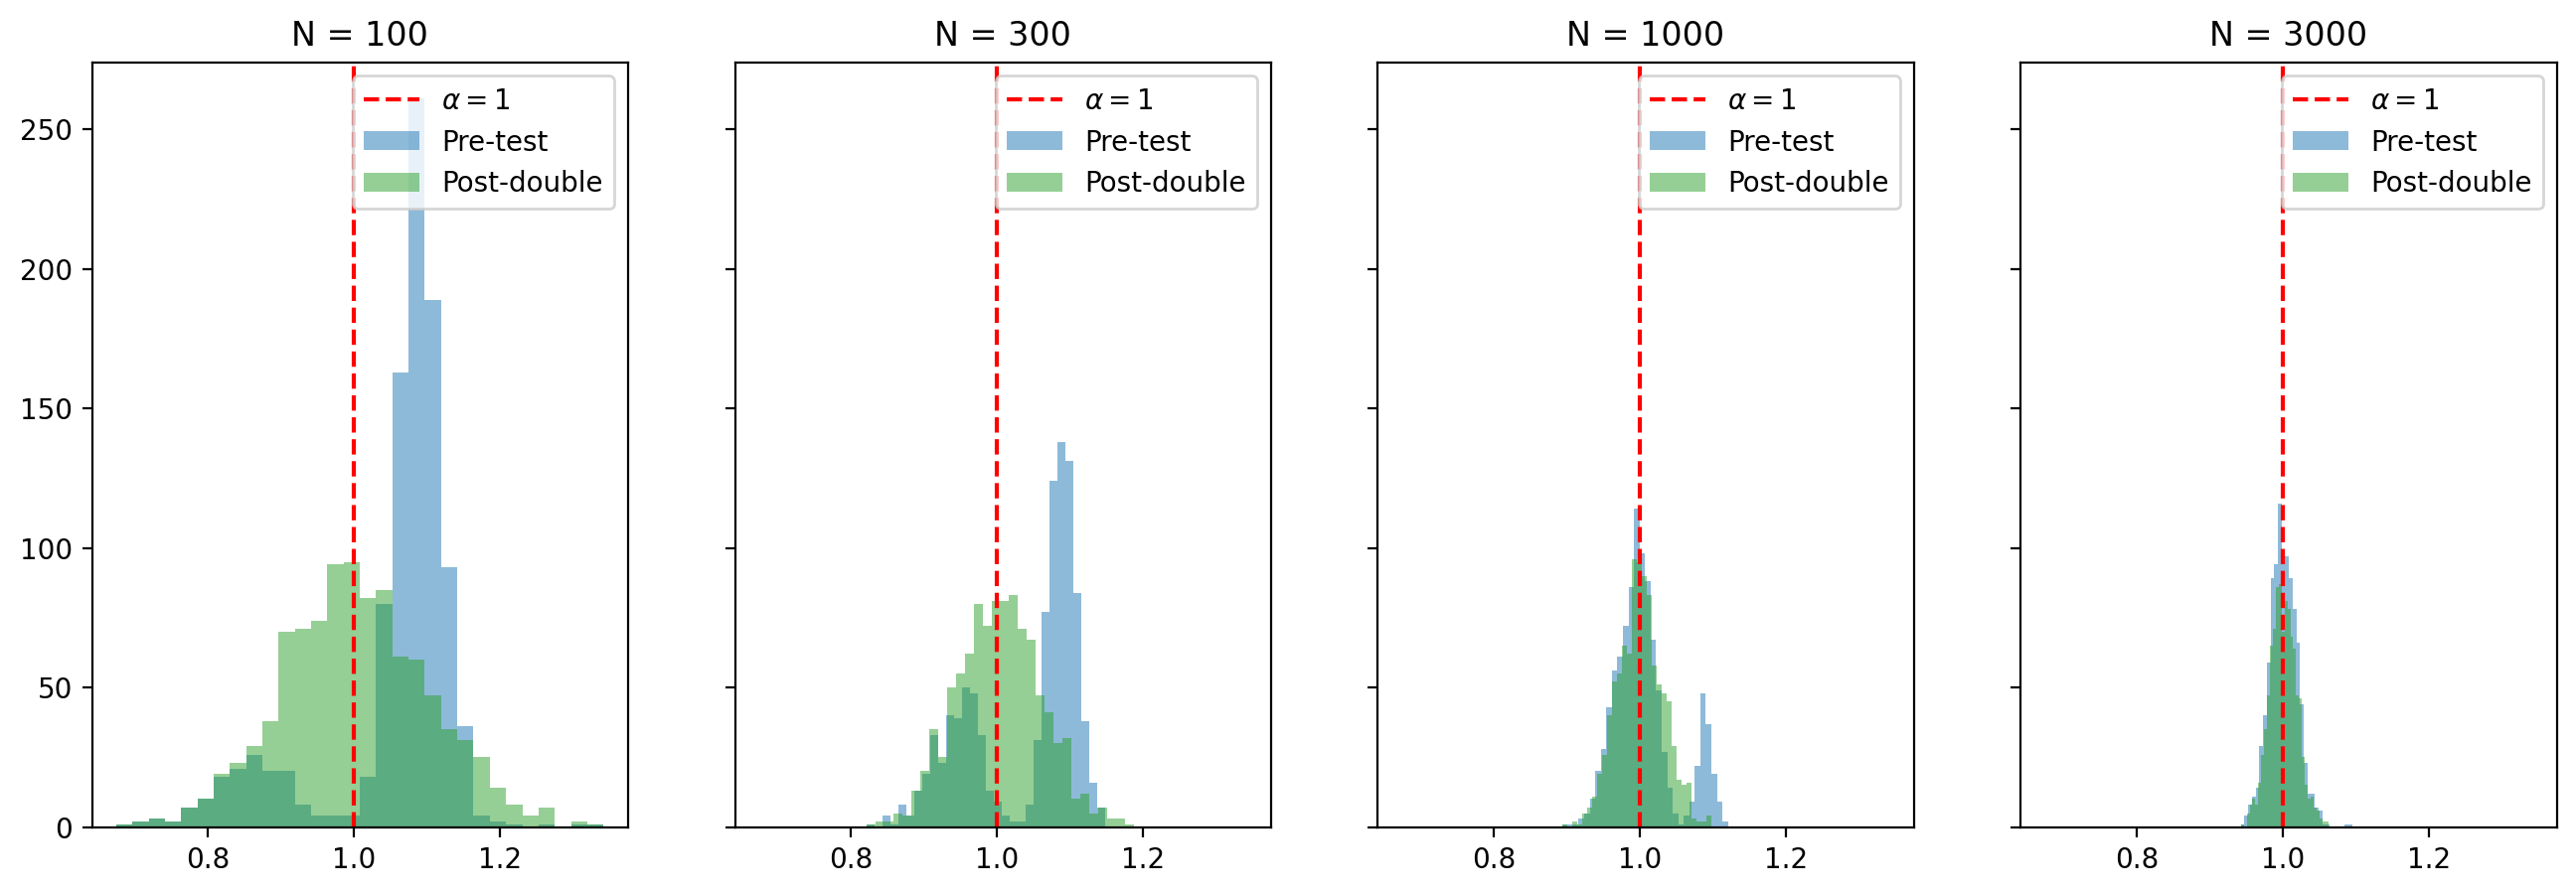

In [16]:
def compare_alphas(alphas, true_alpha):
    
    # Init plot
    fig, axes = plt.subplots(1, len(alphas), figsize=(4*len(alphas), 5), sharey=True, sharex=True)

    # Make one plot for each set of coefficients
    for i, key in enumerate(alphas.keys()):
        axes[i].hist(alphas[key]['Pre-test'], bins=30, lw=.1, alpha=0.5)
        axes[i].hist(alphas[key]['Post-double'], bins=30, lw=.1, alpha=0.5, color='C2')
        axes[i].set_title(key)
        axes[i].axvline(true_alpha, c='r', ls='--')
        axes[i].legend([rf'$\alpha=${true_alpha}', 'Pre-test', 'Post-double'], 
                       prop={'size': 10}, loc='upper right')

compare_alphas(alphas, true_alpha=1)

Para amostras pequenas, a distribuição do estimador pré-teste não é normal, mas sim bimodal. A partir dos gráficos, podemos observar que o estimador pós-duplo é gaussiano também em amostras pequenas.

***Diferentes valores de $\beta$***

Agora repetimos o mesmo exercício, mas para valores diferentes de $\beta$, o coeficiente de *Manag* em *sales*.

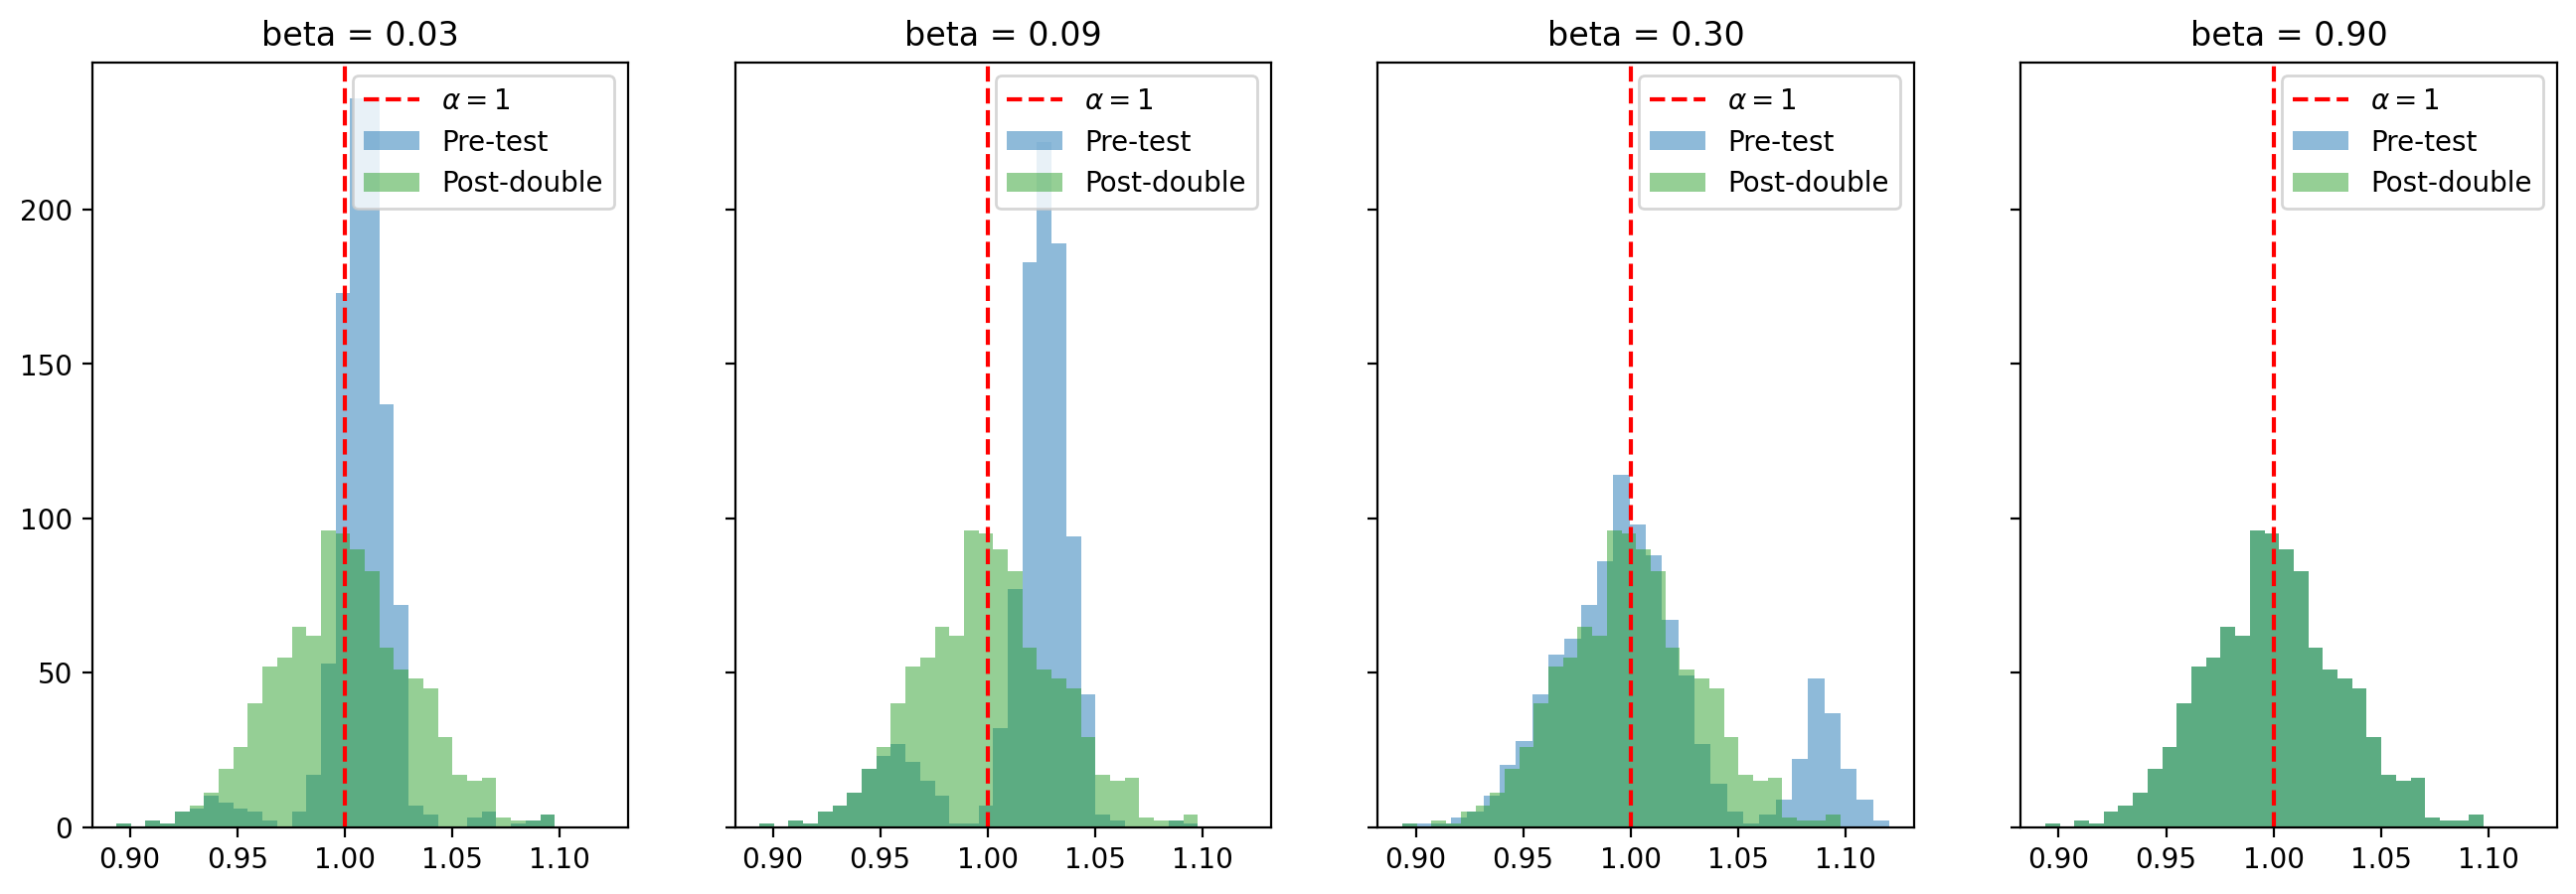

In [17]:
betas = 0.3 * np.array([0.1,0.3,1,3])
alphas = {f'beta = {b:.2f}': pre_test(b=b) for b in betas}
compare_alphas(alphas, true_alpha=1)

Novamente, o estimador de seleção pós-dupla tem uma distribuição gaussiana independentemente do valor de $\beta$, enquanto o estimador de pré-teste sofre de viés de regularização.

***Valor de $\beta$ varia conforme o tamanho da amostra***

Para a última simulação, alteramos o coeficiente em função do tamanho da amostra.

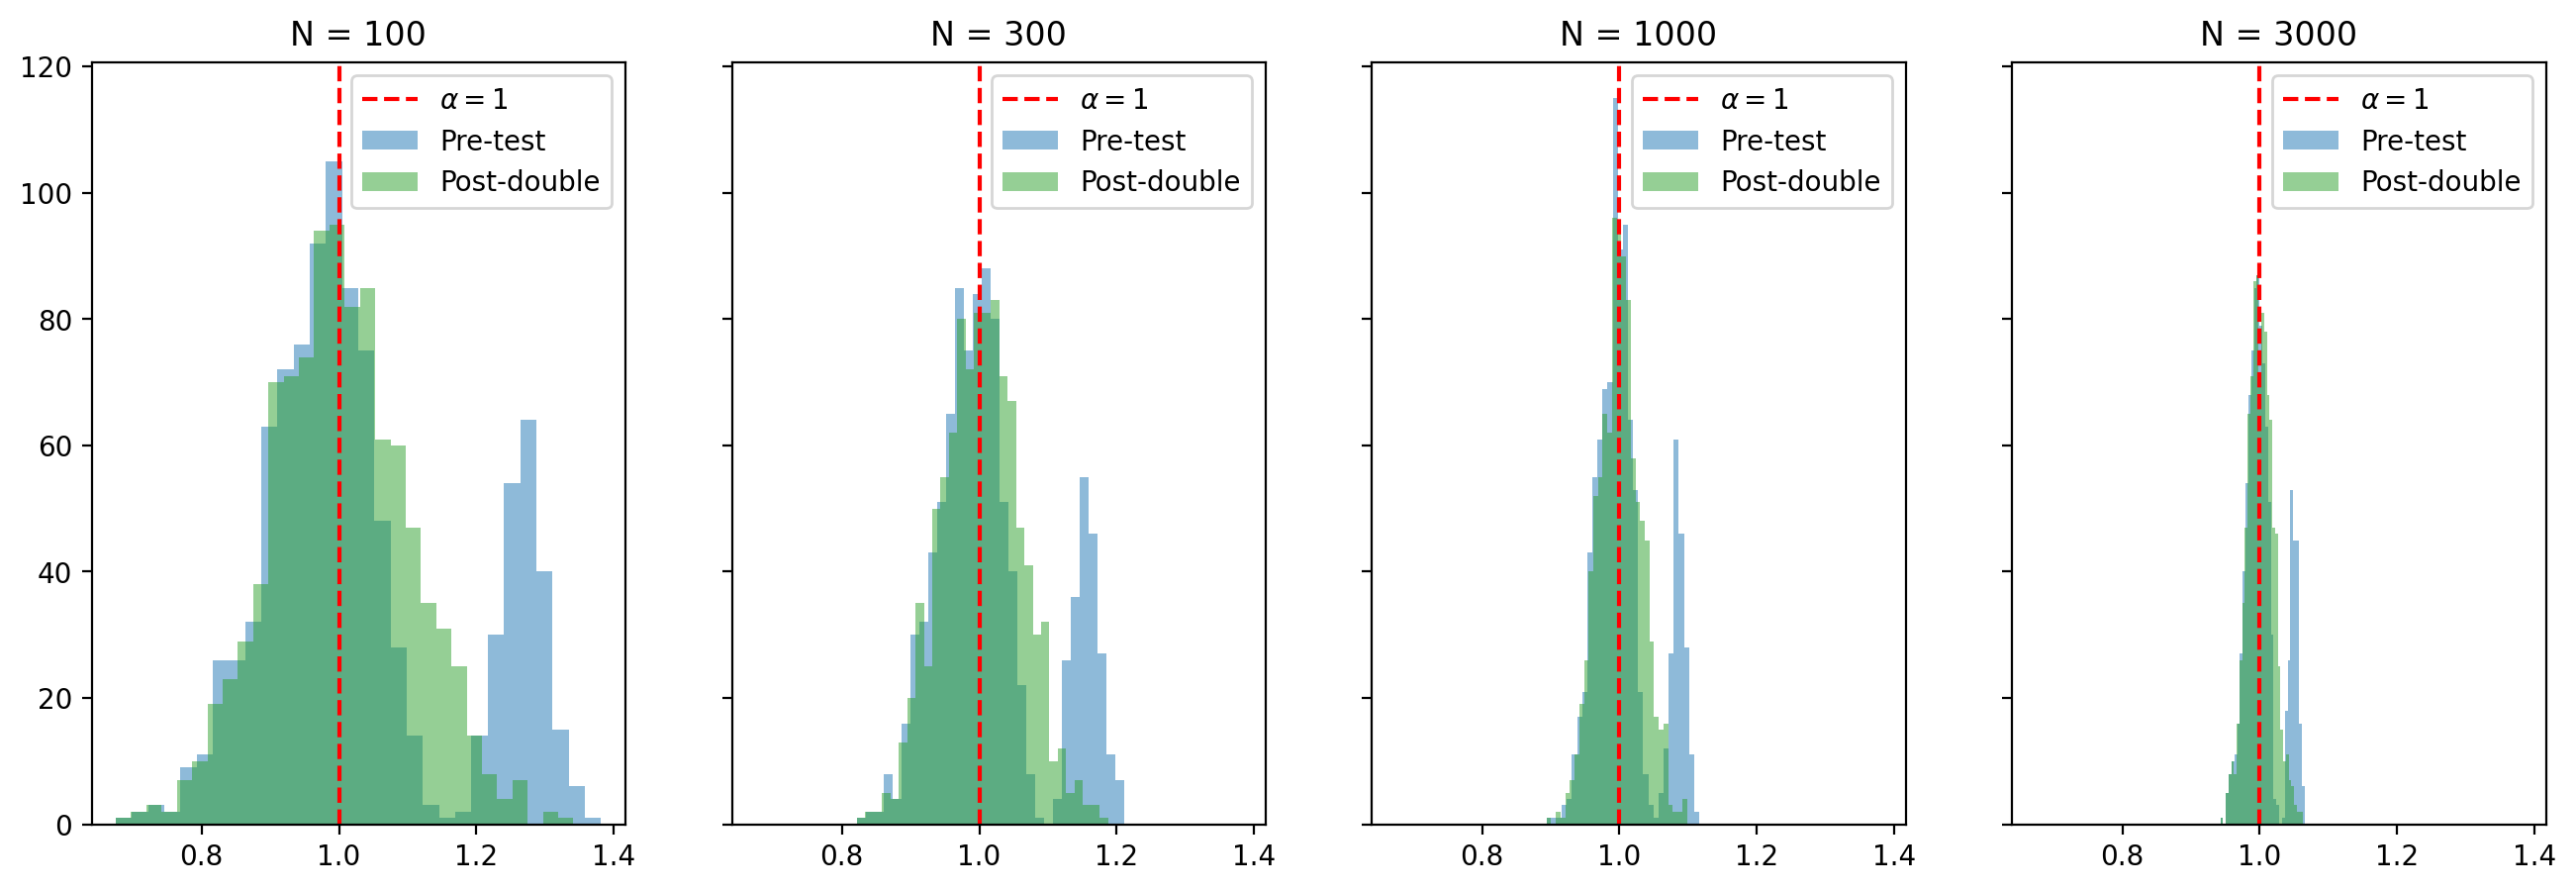

In [18]:
betas = 0.3 * 30 / np.sqrt(Ns)
alphas = {f'N = {n:.0f}':  pre_test(b=b, N=n) for n,b in zip(Ns,betas)}
compare_alphas(alphas, true_alpha=1)

Também neste último caso, o estimador pós-seleção dupla tem um bom desempenho e a inferência não é distorcida.

### Aprendizado de Máquina com Duplo Desviés (*Double Debiased Machine Learning* - DDML)

Até agora, analisamos apenas um exemplo linear e univariado. O que acontece se a dimensão de $X$ aumenta e não sabemos a forma funcional através da qual $X$ afeta $Y$ e $D$? Nesses casos, podemos usar algoritmos de aprendizado de máquina para descobrir essas relações não lineares de alta dimensão.

**Chernozhukov, Chetverikov, Demirer, Duflo, Hansen, Newey e Robins (2018)** investigam esse cenário. Em particular, os autores consideram o seguinte modelo parcialmente linear (Semi-Paramétrico):

$$ Y = \alpha D + g(X) + u $$

$$ D = m(X) + v $$

onde $Y$ é a variável de resultado, $D$ o tratamento/Variável de interesse, e $X$ um conjunto potencialmente de alta dimensão de variáveis de controle.


***Ortogonalização***

Pelo teorema de Frisch-Waugh-Lovell, podemos estimar $\alpha$ a partir da parcialização direta do efeito de $X$ em $D$ 

$$v = D - m(X)$$

e de $X$ em $Y$ 

$$u = Y - g(X)$$

O objetivo do procedimento de ortogonalização é estimar com consistência o parâmetro causal $\alpha$ mesmo quando $D$ é correlacionado com os regressores $X$. Para isso, remove-se o componente previsível de $D$ e $Y$ em relação a $X$ separadamente, garantindo que a estimação final se baseie apenas na variação exógena de $D$. Em outras palavras, ao estimarmos os resíduos dessas regressões parciais, isolamos a parte de $D$ que é ortogonal a $X$, e usamos essa variação exógena para estimar o efeito causal de $D$ sobre $Y$.

Procedimento geral:

1. Divida a amostra em duas: amostra principal e auxiliar.
2. Use a ***amostra auxiliar*** para estimar $\hat{g}(X)$ de
$$ Y = g(X) + u $$

3. Use a ***amostra auxiliar*** para estimar $\hat{m}(X)$ de 
$$ D = m(X) + v $$

4. Use a amostra principal para calcular os componentes ortogonalizados:
$$ \hat{v} = D - \hat{m}(X) $$

$$ \hat{u} = Y - \hat{g}(X) $$

5. Use a amostra principal para estimar o estimador OLS duplamente residualizado como 

$$ \hat{\alpha} = (\hat{v´}D)^{-1}\hat{v´}(Y- \hat{g}(X)) $$

ou seja, o coeficiente é obtido pelo OLS simples dos resíduos, após retirarmos os efeitos de X:

$$ \hat{u} = \alpha \hat{v} + \epsilon $$


O estimador ***é consistente em raiz N***. Isso significa que não apenas o estimador converge para o valor verdadeiro à medida que o tamanho da amostra aumenta (ou seja, é consistente), mas também seu desvio padrão (ou seja, é consistente em raiz N).

A divisão da amostra introduz variabilidade adicional e reduz a eficiência da estimativa, já que apenas parte da amostra é usada em cada etapa. Para recuperar a taxa ótima de convergência $\sqrt{N}$, é comum aplicar cross-fitting, ou seja, trocar os papéis entre amostra auxiliar e principal, estimar novamente $\hat{\alpha}$ e, por fim, tomar a média das estimativas.

Exemplo do procedimento de ortogonalização:

In [53]:
m_y = smf.ols("sales ~  1 + Manag", data=df).fit()
df['resid_y'] = df['sales'] - m_y.predict(df)

In [54]:
m_D = smf.ols("ads ~ 1 + Manag", data=df).fit()
df['resid_D'] = df['ads'] - m_D.predict(df)

In [55]:
smf.ols("resid_y ~ resid_D", df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-6.16e-15,0.031,-2.01e-13,1.000,-0.060,0.060
resid_D,0.9708,0.030,32.561,0.000,0.912,1.029


Vamos comparar com a regressão OLS padrão:

In [56]:
smf.ols('sales ~ ads + Manag', df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.1405,0.185,0.758,0.448,-0.223,0.504
ads,0.9708,0.030,32.545,0.000,0.912,1.029
Manag,0.3381,0.095,3.543,0.000,0.151,0.525


Realmente, o procedimento de ortogonalização recupera o mesmo coeficiente que a regressão OLS padrão. Podemos generalizar para estrutura semi-paramétrica.

***Possivel ponto negativo do DDML***

O problema está relacionado a variáveis ​​de controle ruins (***bad controls***) . Ao condicionar a análise a características adicionais nem sempre é bom para a inferência causal. Dependendo do cenário, pode haver variáveis ​​que queremos deixar de fora da nossa análise, pois sua inclusão pode enviesar o coeficiente de interesse, impedindo uma interpretação causal. O exemplo mais simples são as variáveis ​​que são ***resultados comuns, tanto do tratamento quanto do resultado***.

O modelo de aprendizagem de máquina com duplo desviés pressupõe implicitamente que as variáveis ​​de controle $X$ são causas (fracamente) comuns tanto para o resultado $Y$ e o tratamento $D$ (*backdoor condition*). Se for esse o caso e não existir mais nenhuma relação mediada/indireta entre $X$ e $Y$, não há problema. 

Porém, se, por exemplo, alguma variável entre os controles $X$ ***é um efeito comum em vez de uma causa comum***, sua inclusão distorcerá o coeficiente de interesse. Além disso, é provável que essa variável esteja altamente correlacionada com o resultado $Y$ ou com o tratamento $D$. No último caso, isso implica que a seleção pós-dupla pode incluí-la em casos em que a seleção simples não a teria incluído. Portanto, ***na presença de variáveis ​​de controle ruins, o aprendizado de máquina com viés duplo pode ser ainda pior do que o pré-teste simples***.

**Por fim, como em qualquer método, é crucial ter uma compreensão clara das premissas do método e sempre verificar possíveis violações.**


### Considerações Finais

Nessa aula, discutimos o viés de pre-test e como ele pode afetar a inferência causal em estudos observacionais. Vimos que o pre-test pode levar a um viés de variável omitida, especialmente quando a seleção de variáveis é feita com base nos dados.

Vimos que a solução para esse problema é o procedimento de seleção pós-dupla, que garante a consistência do estimador e a validade dos intervalos de confiança.

Por fim, introduzimos o conceito de Aprendizado de Máquina com Duplo Desviés (DDML), que estende a ideia de seleção pós-dupla para cenários de alta dimensão e não linearidade, mas com o cuidado de evitar variáveis de controle ruins (*bad controls*).